# Classification and Differentiate Statistics

Once we have preprocessed the data and collected them in convenient data-set (one containing only the last istant of simulation of all the events) we want to perform a physical analysis to classify the events and individuate the different classes.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Before starting with the proper analysis, a rescaling of the units from N-body to physical is needed.

In [8]:
def rescaling_physical(data):
    '''
    rescale the data from N-body UNITS to Physical UNITS
    '''
    G_pym = 4.30091e-3                  # in m^3 * kg^-1 * s^-2
    M_scale =  1.988e30                 # in Kg (solar Mass --> 1.988 * 10^30 Kg)
    L_scale = 3.08567758130573e16       # in m (1 pc --> 3.08567758130573 * 10^16 m)
    T_scale = np.sqrt(L_scale**3 / (G_pym * M_scale))

    data['m'] = data['m'] * M_scale
    data['x'] = data['x'] * L_scale
    data['y'] = data['y'] * L_scale
    data['z'] = data['z'] * L_scale
    data['vx'] = data['vx'] * (L_scale / T_scale)
    data['vy'] = data['vy'] * (L_scale / T_scale)
    data['vz'] = data['vz'] * (L_scale / T_scale)
    
    return(data)

The first step is to compute the binding energy between couples of black holes. As a matter of fact, as we know, a negative binding energy identify two BHs that form a binary sistem; and this is the main features that help us to discriminate between the events.

In [9]:
def energy(data, phys=False):
    '''
    add a column with the energy to the dataframe
    '''

    #compute, in order 01 12 20
    N = len(data)
    m = data['m'].values
    x = data['x'].values
    y = data['y'].values
    z = data['z'].values
    vx = data['vx'].values
    vy = data['vy'].values
    vz = data['vz'].values
    
    #mprod
    m_prod = np.zeros(N)
    m_prod[0::3] = m[0::3] * m[1::3]
    m_prod[1::3] = m[1::3] * m[2::3]
    m_prod[2::3] = m[2::3] * m[0::3]
    
    #reduced mass
    mu = np.zeros(N)
    mu[0::3] = m_prod[0::3] / (m[0::3] + m[1::3])
    mu[1::3] = m_prod[1::3] / (m[1::3] + m[2::3])
    mu[2::3] = m_prod[2::3] / (m[2::3] + m[0::3])
    
    #pos_rel
    pos_rel = np.zeros(N)
    pos_rel[0::3] = np.sqrt((x[0::3] - x[1::3])**2 + (y[0::3] - y[1::3])**2 + (z[0::3] - z[1::3])**2)
    pos_rel[1::3] = np.sqrt((x[1::3] - x[2::3])**2 + (y[1::3] - y[2::3])**2 + (z[1::3] - z[2::3])**2)                      
    pos_rel[2::3] = np.sqrt((x[2::3] - x[0::3])**2 + (y[2::3] - y[0::3])**2 + (z[2::3] - z[0::3])**2)
                                                                              
    #v2_rel                                                                         
    v2_rel = np.zeros(N)
    v2_rel[0::3] = (vx[0::3] - vx[1::3])**2 + (vy[0::3] - vy[1::3])**2 + (vz[0::3] - vz[1::3])**2                                      
    v2_rel[1::3] = (vx[1::3] - vx[2::3])**2 + (vy[1::3] - vy[2::3])**2 + (vz[1::3] - vz[2::3])**2
    v2_rel[2::3] = (vx[2::3] - vx[0::3])**2 + (vy[2::3] - vy[0::3])**2 + (vz[2::3] - vz[0::3])**2
             
    # gravitaional constant
    G=1
    if phys:
        G = 4.30091e-3         # in m^3 * kg^-1 * s^-2 # 
    
    
    #binding energy
    BE = np.zeros(N) 
    BE[0::3] = (0.5 * mu[0::3] * v2_rel[0::3]) - (G * m_prod[0::3] / pos_rel[0::3])
    BE[1::3] = (0.5 * mu[1::3] * v2_rel[1::3]) - (G * m_prod[1::3] / pos_rel[1::3])
    BE[2::3] = (0.5 * mu[2::3] * v2_rel[2::3]) - (G * m_prod[2::3] / pos_rel[2::3])
    
    data['BE'] = BE  
    
    return data

Once we computed the binding energy, it is straightforward to classify the events applying the the filters known from theory. <br>
In details:
- $BE_{01} < 0$, $BE_{12}>0$, $BE_{20}>0$ $\longrightarrow$ Fly-by
- $BE_{01} > 0$, $BE_{12}>0$, $BE_{20}<0$ $\longrightarrow$ Exchange1 (bynary system between BH 0 and 2)
- $BE_{01} > 0$, $BE_{12}<0$, $BE_{20}>0$ $\longrightarrow$ Exchange0 (bynary system between BH 1 and 2)
- $BE_{01} > 0$, $BE_{12}>0$, $BE_{20}>0$ $\longrightarrow$ Ionization

Morevorer, merger events are the easisest to identify beacuse, in this case, the simulation sets one of the three masses equal to zero. So:
- $M_0=0$ | $M_1=0$ | $M_2=0$ $\longrightarrow$ Merger

In [10]:
def event(data):
    '''
    return new df with only the first(::3) rows and the corresponing event class
    '''
    
    BE = data['BE'].values
    m = data['m'].values
    
    # maps for the event classes
    fly_by = (BE[0::3] <0) & (BE[1::3] >0) & (BE[2::3] >0)
    exchange1 = (BE[0::3] >0) & (BE[1::3] >0) & (BE[2::3] <0) #bynary tra 0-2
    exchange0 = (BE[0::3] >0) & (BE[1::3] <0) & (BE[2::3] >0) #bynary tra 1_2
    ionization = (BE[0::3] >0) & (BE[1::3] >0) & (BE[2::3] >0)
    merge = (m[0::3]==0) | (m[1::3]==0) | (m[2::3]==0)
    
    # new df
    data_event = data[0::3]
    # identify event class
    ### non sono sicuri sia il metodo migliore dati i warnings
    data_event['event'] = 'unclussified'
    data_event['event'][fly_by] = 'fly_by'
    data_event['event'][exchange1] = 'exchange1'
    data_event['event'][exchange0] = 'exchange0'
    data_event['event'][ionization] = 'ionization'
    data_event['event'][merge] = 'merge'

    return data_event

Due to some workings of the simulation code, it is possible that some events don't happen within the simulation time, and a longer simulation is required. For these reasons it is important to individuate them.<br>
Since all the simulations start with a binary system and a separated third mass as introuder, tt is clear that these (not happened) events can be confused only with Fly-bies. To distinguish between them the idea is to compute the distance between the center of mass of the binary system and the third mass 10 istants before the end of the simulation ($d_{10}$) anfd the same distance at the last instant ($d$) and to compare them. If the distance decrease in time the event isn't happened yet.
- $d_{10} > d \longrightarrow$ not happened
- $d_{10} < d \longrightarrow$ Fly-by

In [11]:
def unhappend(xSC_event, xSC, xSC10):
    '''
    discriminate between flyby and unhappened
    '''

    #map with flyby events
    idx_flyby = xSC_event[xSC_event['event'] == 'fly_by']['simulation'].values
    #back to original df10 to have more info
    xSC10_flyby = xSC10[xSC10.simulation.isin(idx_flyby)]
    xSC_flyby = xSC[xSC.simulation.isin(idx_flyby)]

    xSC10_flyby

    #compute the centre of the mass of the binary

    m = xSC_flyby['m'].values

    x = xSC10_flyby['x'].values
    y = xSC10_flyby['y'].values
    z = xSC10_flyby['z'].values

    #cm10
    x_cm10 = (m[0::3]*x[0::30] + m[1::3]*x[1::30]) / (m[0::3] + m[1::3])
    y_cm10 = (m[0::3]*y[0::30] + m[1::3]*y[1::30]) / (m[0::3] + m[1::3])
    z_cm10 = (m[0::3]*z[0::30] + m[1::3]*z[1::30]) / (m[0::3] + m[1::3])

    dist10 = np.sqrt((x_cm10 - x[2::30])**2 + (y_cm10 - y[2::30])**2 + (z_cm10 - z[2::30])**2)

    #cm
    x_cm = (m[0::3]*x[27::30] + m[1::3]*x[28::30]) / (m[0::3] + m[1::3])
    y_cm = (m[0::3]*y[27::30] + m[1::3]*y[28::30]) / (m[0::3] + m[1::3])
    z_cm = (m[0::3]*z[27::30] + m[1::3]*z[28::30]) / (m[0::3] + m[1::3])

    dist = np.sqrt((x_cm - x[29::30])**2 + (y_cm - y[29::30])**2 + (z_cm - z[29::30])**2)

    #mask
    ok = (dist < dist10)

    xSC_flyby_event = xSC_event[xSC_event.simulation.isin(idx_flyby)]

    xSC_flyby_event['flyby'] = 'false'
    xSC_flyby_event['flyby'][ok] = 'ok'

    return xSC_flyby_event

We can now see the application of this analysis in the two star clusters

# Young Star Cluster (YSC)

First of all we import the new data-set that contains only the last onstants of all the simulations.

In [14]:
#import data YSC
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
YSC_import = pd.read_csv("YSC/YSC_N10000_endsim.dat", sep=",", header=0, names=names)
YSC_import['simulation'] = [(i//3) for i in range(len(YSC_import))]
YSC = YSC_import.copy()

YSC

,m,x,y,z,vx,vy,vz,simulation
0,50.279995,0.113208,0.034386,0.022581,-1.554359,73.003181,95.337515,0
1,42.430295,0.112654,0.034437,0.022792,39.727262,-74.967304,-105.389632,0
2,7.922303,-1.321844,-0.402669,-0.265383,-202.906440,-61.814698,-40.626653,0
3,42.605799,-0.019820,-0.069529,0.122362,241.117960,80.541936,27.483283,1
4,30.012587,-0.019903,-0.069464,0.122363,-349.486512,-139.539435,5.347029,1
...,...,...,...,...,...,...,...,...
29995,3.098252,-5.563291,7.298985,-13.133733,-830.689000,1089.850835,-1961.070821,9998
29996,63.138950,0.160927,-0.211130,0.380030,128.713258,-73.831570,41.613869,9998
29997,39.670667,0.069257,0.330360,0.923332,371.029933,-362.176070,-76.691799,9999
29998,32.617436,0.069270,0.330361,0.923332,-428.369489,549.682340,398.450981,9999


We apply the scaling function

In [15]:
YSC_phys = rescaling_physical(YSC)
YSC_phys

,m,x,y,z,vx,vy,vz,simulation
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0
1,8.435143e+31,3.476133e+15,1.062604e+15,7.033028e+14,2.091230e+07,-3.946254e+07,-5.547675e+07,0
2,1.574954e+31,-4.078784e+16,-1.242506e+16,-8.188868e+15,-1.068093e+08,-3.253905e+07,-2.138573e+07,0
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1
4,5.966502e+31,-6.141322e+14,-2.143431e+15,3.775722e+15,-1.839685e+08,-7.345309e+07,2.814658e+06,1
...,...,...,...,...,...,...,...,...
29995,6.159324e+30,-1.716652e+17,2.252231e+17,-4.052647e+17,-4.372719e+08,5.736938e+08,-1.032301e+09,9998
29996,1.255202e+32,4.965690e+15,-6.514803e+15,1.172651e+16,6.775422e+07,-3.886469e+07,2.190540e+07,9998
29997,7.886529e+31,2.137033e+15,1.019385e+16,2.849105e+16,1.953089e+08,-1.906483e+08,-4.037030e+07,9999
29998,6.484346e+31,2.137444e+15,1.019387e+16,2.849104e+16,-2.254923e+08,2.893509e+08,2.097433e+08,9999


We compute the binding energies

In [16]:
YSC_energy = energy(YSC_phys, phys=True)
YSC_energy

,m,x,y,z,vx,vy,vz,simulation,BE
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0,-1.567506e+48
1,8.435143e+31,3.476133e+15,1.062604e+15,7.033028e+14,2.091230e+07,-3.946254e+07,-5.547675e+07,0,1.161571e+47
2,1.574954e+31,-4.078784e+16,-1.242506e+16,-8.188868e+15,-1.068093e+08,-3.253905e+07,-2.138573e+07,0,1.453900e+47
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1,-4.728382e+48
4,5.966502e+31,-6.141322e+14,-2.143431e+15,3.775722e+15,-1.839685e+08,-7.345309e+07,2.814658e+06,1,3.799008e+47
...,...,...,...,...,...,...,...,...,...
29995,6.159324e+30,-1.716652e+17,2.252231e+17,-4.052647e+17,-4.372719e+08,5.736938e+08,-1.032301e+09,9998,5.112742e+48
29996,1.255202e+32,4.965690e+15,-6.514803e+15,1.172651e+16,6.775422e+07,-3.886469e+07,2.190540e+07,9998,-6.274564e+48
29997,7.886529e+31,2.137033e+15,1.019385e+16,2.849105e+16,1.953089e+08,-1.906483e+08,-4.037030e+07,9999,-4.511801e+49
29998,6.484346e+31,2.137444e+15,1.019387e+16,2.849104e+16,-2.254923e+08,2.893509e+08,2.097433e+08,9999,6.948547e+48


We check the events classes

In [17]:
YSC_event = event(YSC_energy)
YSC_event

/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value,

,m,x,y,z,vx,vy,vz,simulation,BE,event
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0,-1.567506e+48,fly_by
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1,-4.728382e+48,fly_by
6,7.438752e+31,3.484184e+14,1.854050e+15,2.940506e+15,6.395293e+06,9.353303e+05,-2.059155e+06,2,-1.360450e+46,fly_by
9,1.385083e+32,-5.497515e+15,-5.088576e+15,2.994602e+15,6.746996e+07,2.520334e+07,-6.163611e+06,3,-8.477184e+48,fly_by
12,1.127816e+32,7.119860e+15,-3.088062e+15,-2.678559e+15,-3.821588e+08,-1.594987e+08,-4.120214e+07,4,-3.185856e+48,fly_by
...,...,...,...,...,...,...,...,...,...,...
29985,5.279679e+31,-9.858336e+15,-2.192626e+16,2.672254e+14,3.892294e+07,-1.070873e+08,5.883044e+07,9995,2.223681e+48,exchange1
29988,9.781779e+31,-1.524748e+16,-8.046017e+15,-1.785259e+15,-1.480240e+08,-1.957547e+07,-5.367927e+06,9996,-2.056932e+49,fly_by
29991,1.473872e+32,4.646662e+15,4.989251e+15,9.167022e+15,-7.903314e+07,-1.512724e+08,2.749785e+07,9997,-4.494624e+48,fly_by
29994,8.733879e+31,4.969695e+15,-6.520387e+15,1.172723e+16,-6.653660e+07,1.539681e+07,4.131848e+07,9998,4.608027e+48,exchange1


In the end we can perform a summary statistics that show us the composition of the young star cluster by type of event.

In [18]:
#check the events
YSC_event[['simulation','event']].groupby('event').count()

,simulation
event,
exchange0,443
exchange1,1678
fly_by,7617
ionization,63
merge,11
unclussified,188


Here we observe how the great majority of the statistics is occupied by Fly-bies events ($\sim 75\%$), while only 11 simulations leads to Mergers. <br>
Moreover, it is important to notice how, in this case, a not so low number of events are classified as 'unclussified' beacuse they present more then one negative binding energy.

### Discriminate Fly-bies from not happend events

We import the new data-set with only the last 10 istants of all the simulations.

In [19]:
#import data YSC10
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
YSC_import10 = pd.read_csv("YSC/YSC_N10000_last10_from_end.dat", sep=",", header=0, names=names)
YSC_import10['simulation'] = [(i//30) for i in range(len(YSC_import10))]
YSC10 = YSC_import10.copy()

YSC10

,m,x,y,z,vx,vy,vz,simulation
0,50.279995,0.113208,0.034386,0.022581,-1.554359,73.003181,95.337515,0
1,42.430295,0.112654,0.034437,0.022792,39.727262,-74.967304,-105.389632,0
2,7.922303,-1.321844,-0.402669,-0.265383,-202.906440,-61.814698,-40.626653,0
3,50.279995,0.112953,0.034264,0.022483,168.122092,6.734108,-34.460265,0
4,42.430295,0.112702,0.034504,0.022857,-161.339668,3.561711,48.421040,0
...,...,...,...,...,...,...,...,...
299995,32.617436,0.068714,0.327718,0.915943,-1099.252384,513.215024,411.100627,9999
299996,7.494764,-0.662701,-3.160876,-8.834402,-99.628316,-475.193393,-1328.131900,9999
299997,39.670667,0.068638,0.327385,0.915018,2316.053649,485.923064,244.154154,9999
299998,32.617436,0.068640,0.327388,0.915020,-2793.987341,-481.810711,8.224944,9999


We rescale the physical quantities.

In [20]:
YSC10_phys = rescaling_physical(YSC10)
YSC10_phys

,m,x,y,z,vx,vy,vz,simulation
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0
1,8.435143e+31,3.476133e+15,1.062604e+15,7.033028e+14,2.091230e+07,-3.946254e+07,-5.547675e+07,0
2,1.574954e+31,-4.078784e+16,-1.242506e+16,-8.188868e+15,-1.068093e+08,-3.253905e+07,-2.138573e+07,0
3,9.995663e+31,3.485376e+15,1.057263e+15,6.937488e+14,8.849890e+07,3.544812e+06,-1.813977e+07,0
4,8.435143e+31,3.477615e+15,1.064676e+15,7.053070e+14,-8.492866e+07,1.874873e+06,2.548867e+07,0
...,...,...,...,...,...,...,...,...
299995,6.484346e+31,2.120282e+15,1.011232e+16,2.826304e+16,-5.786427e+08,2.701547e+08,2.164020e+08,9999
299996,1.489959e+31,-2.044881e+16,-9.753444e+16,-2.726011e+17,-5.244401e+07,-2.501402e+08,-6.991241e+08,9999
299997,7.886529e+31,2.117943e+15,1.010204e+16,2.823451e+16,1.219163e+09,2.557883e+08,1.285219e+08,9999
299998,6.484346e+31,2.118016e+15,1.010213e+16,2.823456e+16,-1.470746e+09,-2.536235e+08,4.329583e+06,9999


And we classify them checking the disntances in the two different instants.

In [21]:
YSC_flyby_event = unhappend(YSC_event, YSC_phys, YSC10_phys)
YSC_flyby_event

/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value,

,m,x,y,z,vx,vy,vz,simulation,BE,event,flyby
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0,-1.567506e+48,fly_by,ok
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1,-4.728382e+48,fly_by,ok
6,7.438752e+31,3.484184e+14,1.854050e+15,2.940506e+15,6.395293e+06,9.353303e+05,-2.059155e+06,2,-1.360450e+46,fly_by,false
9,1.385083e+32,-5.497515e+15,-5.088576e+15,2.994602e+15,6.746996e+07,2.520334e+07,-6.163611e+06,3,-8.477184e+48,fly_by,ok
12,1.127816e+32,7.119860e+15,-3.088062e+15,-2.678559e+15,-3.821588e+08,-1.594987e+08,-4.120214e+07,4,-3.185856e+48,fly_by,ok
...,...,...,...,...,...,...,...,...,...,...,...
29976,6.006614e+31,3.001354e+14,-9.534466e+14,-2.502064e+15,1.158078e+07,1.262088e+07,-1.151217e+07,9992,-2.413108e+47,fly_by,ok
29982,7.981648e+31,-3.487804e+15,-1.288624e+16,3.424570e+15,1.149023e+07,-7.775980e+07,4.070138e+07,9994,-1.948060e+48,fly_by,ok
29988,9.781779e+31,-1.524748e+16,-8.046017e+15,-1.785259e+15,-1.480240e+08,-1.957547e+07,-5.367927e+06,9996,-2.056932e+49,fly_by,ok
29991,1.473872e+32,4.646662e+15,4.989251e+15,9.167022e+15,-7.903314e+07,-1.512724e+08,2.749785e+07,9997,-4.494624e+48,fly_by,ok


Here there is the summary of the two classes, in which 'flyby=false' indicates an event that is not happened yet.

In [22]:
#check the events
YSC_flyby_event[['simulation','flyby']].groupby('flyby').count()

,simulation
flyby,
false,389
ok,7228


Also in this case we can't not notice a not so negligible (but still low) number of representatives of this class.

# Nuclear Star Cluster (NSC)

Here we do the same things fro the nuclear star cluesters.<br>
Starting by importing he data.

In [23]:
#import data NSC
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
NSC_import = pd.read_csv("NSC/NSC_N10000_endsim.dat", sep=",", header=0, names=names)
NSC_import['simulation'] = [(i//3) for i in range(len(NSC_import))]
NSC = NSC_import.copy()

NSC

,m,x,y,z,vx,vy,vz,simulation
0,39.689111,1.925802,0.350002,0.968372,1388.557614,3488.776785,508.139712,0
1,26.458487,1.925801,0.350003,0.968372,-1365.137573,-5102.896640,-401.311300,0
2,5.531187,-23.030705,-4.185689,-11.580781,-3433.465959,-624.011507,-1726.487191,0
3,40.231075,0.243291,1.429614,1.285392,54.994388,247.569907,193.816131,1
4,39.334465,0.240934,1.430763,1.285734,17.143140,180.294609,191.428339,1
...,...,...,...,...,...,...,...,...
29995,26.665704,-0.394099,-0.925569,0.727975,-94.481573,57.342166,-27.623747,9998
29996,20.899618,1.151319,2.703387,-2.126038,171.982950,403.838089,-317.588862,9998
29997,35.115653,0.082301,0.469057,0.113693,215.911607,-68.121620,10.964345,9999
29998,28.498771,0.082259,0.469373,0.113706,-238.441375,241.305907,24.625440,9999


Rescaling the data

In [24]:
NSC_phys = rescaling_physical(NSC)
NSC_phys

,m,x,y,z,vx,vy,vz,simulation
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0
1,5.259947e+31,5.942400e+16,1.079995e+16,2.988083e+16,-7.186038e+08,-2.686148e+09,-2.112489e+08,0
2,1.099600e+31,-7.106533e+17,-1.291569e+17,-3.573456e+17,-1.807365e+09,-3.284776e+08,-9.088170e+08,0
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1
4,7.819692e+31,7.434450e+15,4.414874e+16,3.967359e+16,9.024091e+06,9.490647e+07,1.007672e+08,1
...,...,...,...,...,...,...,...,...
29995,5.301142e+31,-1.216063e+16,-2.856009e+16,2.246296e+16,-4.973478e+07,3.018472e+07,-1.454105e+07,9998
29996,4.154844e+31,3.552600e+16,8.341780e+16,-6.560269e+16,9.053124e+07,2.125790e+08,-1.671777e+08,9998
29997,6.980992e+31,2.539547e+15,1.447360e+16,3.508192e+15,1.136551e+08,-3.585899e+07,5.771594e+06,9999
29998,5.665556e+31,2.538234e+15,1.448333e+16,3.508586e+15,-1.255147e+08,1.270226e+08,1.296275e+07,9999


Computing the binding energy

In [25]:
NSC_energy = energy(NSC_phys, phys=True)
NSC_energy

,m,x,y,z,vx,vy,vz,simulation,BE
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0,-1.443213e+50
1,5.259947e+31,5.942400e+16,1.079995e+16,2.988083e+16,-7.186038e+08,-2.686148e+09,-2.112489e+08,0,3.288023e+49
2,1.099600e+31,-7.106533e+17,-1.291569e+17,-3.573456e+17,-1.807365e+09,-3.284776e+08,-9.088170e+08,0,6.038479e+49
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1,-2.970139e+47
4,7.819692e+31,7.434450e+15,4.414874e+16,3.967359e+16,9.024091e+06,9.490647e+07,1.007672e+08,1,1.019760e+49
...,...,...,...,...,...,...,...,...,...
29995,5.301142e+31,-1.216063e+16,-2.856009e+16,2.246296e+16,-4.973478e+07,3.018472e+07,-1.454105e+07,9998,8.878517e+47
29996,4.154844e+31,3.552600e+16,8.341780e+16,-6.560269e+16,9.053124e+07,2.125790e+08,-1.671777e+08,9998,2.884724e+48
29997,6.980992e+31,2.539547e+15,1.447360e+16,3.508192e+15,1.136551e+08,-3.585899e+07,5.771594e+06,9999,-4.210849e+47
29998,5.665556e+31,2.538234e+15,1.448333e+16,3.508586e+15,-1.255147e+08,1.270226e+08,1.296275e+07,9999,1.787127e+48


Classifing the events

In [26]:
NSC_event = event(NSC_energy)
NSC_event

/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value,

,m,x,y,z,vx,vy,vz,simulation,BE,event
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0,-1.443213e+50,fly_by
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1,-2.970139e+47,fly_by
6,1.133926e+32,-2.160735e+16,-2.355496e+16,-2.281402e+16,-1.767717e+08,-6.417639e+07,-2.557021e+07,2,-3.623863e+48,fly_by
9,8.265942e+31,6.947565e+15,-4.621108e+16,-7.447568e+16,3.153776e+08,9.450330e+07,1.788807e+08,3,-2.801992e+49,fly_by
12,4.989323e+31,-6.868574e+16,1.102749e+16,-5.128862e+16,-1.800128e+08,9.725159e+07,-7.321954e+07,4,-1.131312e+48,fly_by
...,...,...,...,...,...,...,...,...,...,...
29985,9.768942e+31,2.598234e+16,2.316585e+15,6.284092e+15,-8.487668e+07,7.278035e+07,1.960410e+07,9995,-1.736197e+49,fly_by
29988,1.163967e+32,-1.632259e+16,6.776702e+14,3.202543e+15,-4.029223e+07,-1.292470e+08,-9.758081e+07,9996,-1.596654e+50,fly_by
29991,1.809707e+32,7.176699e+15,3.115295e+15,-9.620820e+15,4.770766e+06,8.663704e+06,-2.554496e+07,9997,-6.797716e+47,fly_by
29994,6.834522e+31,-1.216468e+16,-2.855897e+16,2.245799e+16,-1.645939e+07,-1.526436e+08,1.129094e+08,9998,-1.637405e+48,fly_by


In [27]:
#check the events
NSC_event[['simulation','event']].groupby('event').count()

,simulation
event,
exchange0,313
exchange1,727
fly_by,7928
ionization,1009
merge,22
unclussified,1


In this case the Fly-bies still occupy the vast majority of the data ($\sim 80 \%$) but we observe the double of the Mergers and only one unclussified event.

### Discriminate fly-byes from unhappend

Again, we import the data.

In [28]:
#import data NSC10
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
NSC_import10 = pd.read_csv("NSC/NSC_N10000_last10_from_end.dat", sep=",", header=0, names=names)
NSC_import10['simulation'] = [(i//30) for i in range(len(NSC_import10))]
NSC10 = NSC_import10.copy()

NSC10

,m,x,y,z,vx,vy,vz,simulation
0,39.689111,1.925802,0.350002,0.968372,1388.557614,3488.776785,508.139712,0
1,26.458487,1.925801,0.350003,0.968372,-1365.137573,-5102.896640,-401.311300,0
2,5.531187,-23.030705,-4.185689,-11.580781,-3433.465959,-624.011507,-1726.487191,0
3,39.689111,1.923875,0.349652,0.967403,1503.361920,-1595.893660,-74.758195,0
4,26.458487,1.923877,0.349653,0.967403,-1537.350023,2524.374309,473.065972,0
...,...,...,...,...,...,...,...,...
299995,28.498771,0.081633,0.465288,0.112777,296.812645,308.045538,25.824451,9999
299996,4.276117,-1.214212,-6.923836,-1.677817,-183.949852,-1048.798890,-254.159315,9999
299997,35.115653,0.082049,0.464879,0.112663,25.687150,119.699532,19.020444,9999
299998,28.498771,0.080903,0.465020,0.112672,-4.050348,9.876199,14.698867,9999


We rescale the physical quantities.

In [29]:
NSC10_phys = rescaling_physical(NSC10)
NSC10_phys

,m,x,y,z,vx,vy,vz,simulation
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0
1,5.259947e+31,5.942400e+16,1.079995e+16,2.988083e+16,-7.186038e+08,-2.686148e+09,-2.112489e+08,0
2,1.099600e+31,-7.106533e+17,-1.291569e+17,-3.573456e+17,-1.807365e+09,-3.284776e+08,-9.088170e+08,0
3,7.890195e+31,5.936457e+16,1.078915e+16,2.985095e+16,7.913646e+08,-8.400730e+08,-3.935246e+07,0
4,5.259947e+31,5.936464e+16,1.078916e+16,2.985095e+16,-8.092559e+08,1.328822e+09,2.490203e+08,0
...,...,...,...,...,...,...,...,...
299995,5.665556e+31,2.518934e+15,1.435729e+16,3.479920e+15,1.562412e+08,1.621541e+08,1.359390e+07,9999
299996,8.500921e+30,-3.746668e+16,-2.136473e+17,-5.177202e+16,-9.683058e+07,-5.520842e+08,-1.337886e+08,9999
299997,6.980992e+31,2.531773e+15,1.434468e+16,3.476421e+15,1.352163e+07,6.300943e+07,1.001230e+07,9999
299998,5.665556e+31,2.496397e+15,1.434902e+16,3.476692e+15,-2.132090e+06,5.198798e+06,7.737434e+06,9999


And we check the event that didn't happen.

In [30]:
NSC_flyby_event = unhappend(NSC_event, NSC_phys, NSC10_phys)
NSC_flyby_event

/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/giulio/.local/lib/python3.6/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value,

,m,x,y,z,vx,vy,vz,simulation,BE,event,flyby
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0,-1.443213e+50,fly_by,ok
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1,-2.970139e+47,fly_by,ok
6,1.133926e+32,-2.160735e+16,-2.355496e+16,-2.281402e+16,-1.767717e+08,-6.417639e+07,-2.557021e+07,2,-3.623863e+48,fly_by,ok
9,8.265942e+31,6.947565e+15,-4.621108e+16,-7.447568e+16,3.153776e+08,9.450330e+07,1.788807e+08,3,-2.801992e+49,fly_by,ok
12,4.989323e+31,-6.868574e+16,1.102749e+16,-5.128862e+16,-1.800128e+08,9.725159e+07,-7.321954e+07,4,-1.131312e+48,fly_by,ok
...,...,...,...,...,...,...,...,...,...,...,...
29985,9.768942e+31,2.598234e+16,2.316585e+15,6.284092e+15,-8.487668e+07,7.278035e+07,1.960410e+07,9995,-1.736197e+49,fly_by,ok
29988,1.163967e+32,-1.632259e+16,6.776702e+14,3.202543e+15,-4.029223e+07,-1.292470e+08,-9.758081e+07,9996,-1.596654e+50,fly_by,ok
29991,1.809707e+32,7.176699e+15,3.115295e+15,-9.620820e+15,4.770766e+06,8.663704e+06,-2.554496e+07,9997,-6.797716e+47,fly_by,ok
29994,6.834522e+31,-1.216468e+16,-2.855897e+16,2.245799e+16,-1.645939e+07,-1.526436e+08,1.129094e+08,9998,-1.637405e+48,fly_by,ok


In [31]:
#check the events
NSC_flyby_event[['simulation','flyby']].groupby('flyby').count()

,simulation
flyby,
false,1
ok,7927


In this case there is only a case in which the simulation time is not enough to observe an event.

<br>

# MERGERS

In this section we concentrate only on the Mergers, which are the most interesting events since we can observe them trough the gravitational waves; and we start collecting all the masses the compose the binary sistems in the events that can lead to Mergers, i.e. Fly-bies and Exchanges. Having care of keep the first mass larger then the second one.

In [88]:
def tot_masses(xSC_event, xSC, xSC_flyby_event):
    '''
    return concatenate array of all masses of binary system in fly-bies and exchanges
    '''
    
    idx_flyby = xSC_event[xSC_event['event']=='fly_by']['simulation'].values
    xSC_flyby = xSC[xSC.simulation.isin(idx_flyby)]
    idx_flyby_clear = xSC_flyby_event[xSC_flyby_event['flyby']=='ok']['simulation'].values
    xSC_flyby_clear = xSC_flyby[xSC_flyby.simulation.isin(idx_flyby_clear)]
    m1_fb = xSC_flyby_clear['m'][0::3].values
    m2_fb = xSC_flyby_clear['m'][1::3].values

    idx_exchange0 = xSC_event[xSC_event['event']=='exchange0']['simulation'].values
    xSC_exchange0 = xSC[xSC.simulation.isin(idx_exchange0)]
    m1_e0 = xSC_exchange0['m'][2::3].values
    m2_e0 = xSC_exchange0['m'][1::3].values
    idx_e0 = np.where((m1_e0 > m2_e0) == False)
    m1_e0_copy = m1_e0.copy()
    m1_e0[idx_e0] = m2_e0[idx_e0]
    m2_e0[idx_e0] = m1_e0_copy[idx_e0]

    idx_exchange1 = xSC_event[xSC_event['event']=='exchange1']['simulation'].values
    xSC_exchange1 = xSC[xSC.simulation.isin(idx_exchange1)]
    m1_e1 = xSC_exchange0['m'][2::3].values
    m2_e1 = xSC_exchange0['m'][0::3].values
    idx_e1 = np.where((m1_e1 > m2_e1) == False)
    m1_e1_copy = m1_e1.copy()
    m1_e1[idx_e1] = m2_e1[idx_e1]
    m2_e1[idx_e1] = m1_e1_copy[idx_e1]

    m1 = np.concatenate((m1_fb, m1_e0, m1_e1))
    m2 = np.concatenate((m2_fb, m2_e0, m1_e1))
    
    return m1, m2 #, m1_fb, m2_fb, m1_e0, m2_e0, m1_e1, m2_e1

## YSC

We start with a 2D histrogram that represnt the masses distribution of the binary systems for Fly-bies and Exhanges events all toghther.

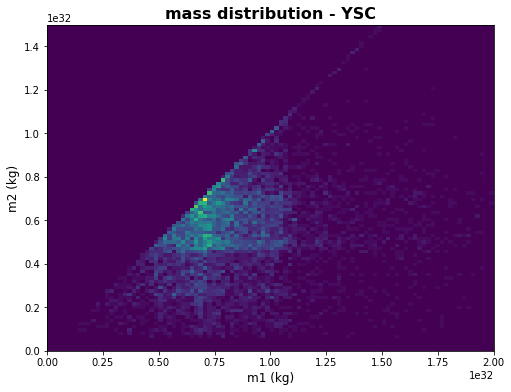

In [89]:
m1y, m2y = tot_masses(YSC_event, YSC_phys, YSC_flyby_event)
plt.figure(figsize=(8,6))
plt.title('mass distribution - YSC', fontsize = 16, fontweight = "bold")
plt.hist2d(m1y, m2y, bins=100, range=[[0,2e32],[0, 1.5e32]]) #, cmap=plt.cm.plasma,)
plt.xlabel('m1 (kg)', fontsize = 12)
plt.ylabel('m2 (kg)', fontsize = 12)
#plt.legend(loc='best')
plt.show()

We collect the data of the Mergers.

In [90]:
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'simulation']
YSC_merge_nb = pd.read_csv( 'YSC/start_merge_YSC.dat' , sep=",", header=None, names=names)
YSC_merge = rescaling_physical(YSC_merge_nb)
YSC_merge

,m,x,y,z,vx,vy,vz,simulation
0,8.363261e+31,2.951333e+12,3.111635e+12,1.623625e+12,3.723731e+08,-1.104842e+09,-6.953398e+06,9926
1,7.021743e+31,3.072050e+12,3.170111e+12,1.623625e+12,-4.757222e+08,1.301968e+09,-6.953398e+06,9926
2,4.730599e+31,-9.777601e+12,-1.020656e+13,-5.280403e+12,4.780484e+07,2.071493e+07,2.261406e+07,9926
3,6.692858e+31,-6.544249e+11,-6.094452e+10,-6.842067e+11,-6.103931e+08,1.987142e+08,5.239239e+06,8856
4,5.621625e+31,-7.978638e+11,-1.104280e+11,-6.842067e+11,7.343934e+08,-2.327926e+08,5.239239e+06,8856
5,1.275206e+31,6.952028e+12,8.066760e+11,6.607290e+12,-3.388481e+07,-1.669809e+07,-5.059460e+07,8856
6,7.804409e+31,9.313039e+12,-3.488628e+12,2.014483e+13,-9.232922e+07,1.290077e+08,-2.921115e+07,8430
7,6.135837e+31,8.063636e+12,-3.634568e+12,2.014483e+13,9.336316e+07,-1.491256e+08,-2.921115e+07,8430
8,6.330961e+31,-1.929564e+13,7.823109e+12,-4.435723e+13,2.333198e+07,-1.450308e+07,6.432051e+07,8430
9,7.978214e+31,1.441719e+13,-1.124013e+13,-6.175520e+12,-2.718237e+08,3.066754e+08,1.296172e+06,5111


And we overimpose the masses of the Mergers to the 2D distribution. Having care of highlight the type of event from wich the Mergers come from (Fly-by or Exchange).

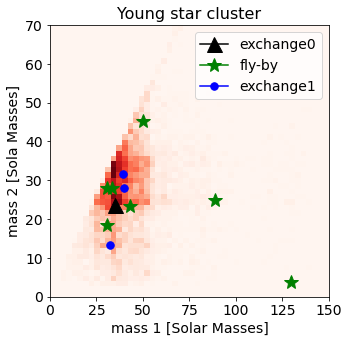

In [99]:
#9926 - ex0
m9926_1 = YSC_merge['m'][1]
m9926_2 = YSC_merge['m'][2]
#8856 - fb
m8856_1 = YSC_merge['m'][3]
m8856_2 = YSC_merge['m'][4]
#8430 - ex1
m8430_1 = YSC_merge['m'][6]
m8430_2 = YSC_merge['m'][8]
#5511 - ex1
m5511_1 = YSC_merge['m'][9]
m5511_2 = YSC_merge['m'][11]
#9768 - fb
m9768_1 = YSC_merge['m'][12]
m9768_2 = YSC_merge['m'][13]
#4789 - fb 
m4789_1 = YSC_merge['m'][15]
m4789_2 = YSC_merge['m'][16]
#1758 - fb
m1758_1 = YSC_merge['m'][18]
m1758_2 = YSC_merge['m'][19]
#7911 - ex1
m7911_1 = YSC_merge['m'][21]
m7911_2 = YSC_merge['m'][23]
#7412 - fb
m7412_1 = YSC_merge['m'][24]
m7412_2 = YSC_merge['m'][25]
#9208 - fb
m9208_1 = YSC_merge['m'][27]
m9208_2 = YSC_merge['m'][28]
#2416 - fb
m2416_1 = YSC_merge['m'][30]
m2416_2 = YSC_merge['m'][31]

fig = plt.figure(figsize=(5,5))
plt.title('Young star cluster', fontsize = 16)
plt.hist2d(m1y/2e30, m2y/2e30, bins=50, range=[[0,150],[0, 70]], cmap=plt.cm.Reds)
plt.plot(m9926_1/2e30, m9926_2/2e30, marker='^', markersize=15, label='exchange0', c='black')
plt.plot(m8856_1/2e30, m8856_2/2e30, marker='*', markersize=15, label='fly-by', c='green')
plt.plot(m8430_1/2e30, m8430_2/2e30, marker='.', markersize=15, label='exchange1', c='blue')
plt.plot(m5511_1/2e30, m5511_2/2e30, marker='.', markersize=15, c='blue') #label='ex1'
plt.plot(m9768_1/2e30, m9768_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m4789_1/2e30, m4789_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m1758_1/2e30, m1758_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m7911_1/2e30, m7911_2/2e30, marker='.', markersize=15, c='blue') #label='ex1'
plt.plot(m7412_1/2e30, m7412_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m9208_1/2e30, m9208_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2416_1/2e30, m2416_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.xlabel('mass 1 [Solar Masses]', fontsize = 14)
plt.ylabel('mass 2 [Sola Masses]', fontsize = 14)
plt.tick_params(axis = "x", labelsize = 14)
plt.tick_params(axis = "y", labelsize = 14)
plt.legend(loc='best', fontsize = 14)
plt.show()
fig.savefig("mass_2d_young.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

The Mergers are mostly distributed in the denser region of events and there is a slight majority of them that comse from Fly-bies.

## NSC

Here we repaet exactly the same things for Nuclear Star Cluster.<br>
Starting from the 2D distribution.

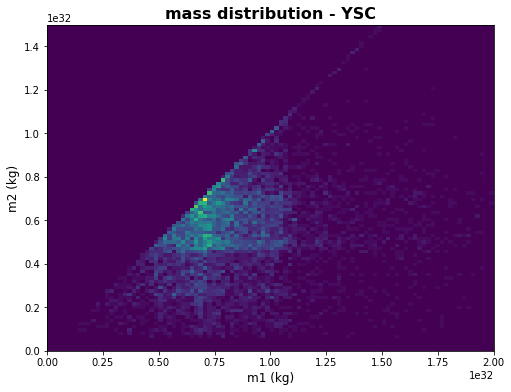

In [92]:
m1n, m2n = tot_masses(YSC_event, YSC_phys, YSC_flyby_event)
plt.figure(figsize=(8,6))
plt.title('mass distribution - YSC', fontsize = 16, fontweight = "bold")
plt.hist2d(m1n, m2n, bins=100, range=[[0,2e32],[0, 1.5e32]]) #, cmap=plt.cm.plasma,)
plt.xlabel('m1 (kg)', fontsize = 12)
plt.ylabel('m2 (kg)', fontsize = 12)
#plt.legend(loc='best')
plt.show()

In [93]:
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'simulation']
NSC_merge_nb = pd.read_csv( 'NSC/start_merge_NSC.dat' , sep=",", header=None, names=names)
NSC_merge = rescaling_physical(NSC_merge_nb)
NSC_merge

,m,x,y,z,vx,vy,vz,simulation
0,6.483813e+31,-6.087989e+11,-2.938493e+11,5.493227e+10,3.824410e+08,4.389736e+08,-1.742570e+07,1161
1,2.181282e+31,-6.501965e+11,-2.872902e+11,5.493227e+10,-5.228839e+08,-9.736829e+08,-1.742570e+07,1161
2,3.301243e+31,1.625327e+12,7.669610e+11,-1.441861e+11,-4.056409e+08,-2.188104e+08,4.573894e+07,1161
3,9.912763e+31,7.377236e+12,6.686717e+12,3.340447e+12,-4.357798e+07,2.013590e+07,-9.069085e+07,5480
4,7.077555e+31,6.903757e+12,6.760222e+12,3.340447e+12,-4.480795e+08,-5.023775e+08,-9.069085e+07,5480
...,...,...,...,...,...,...,...,...
61,6.512329e+31,-1.077937e+12,4.082009e+11,-2.431106e+11,-1.648682e+09,-1.057988e+08,1.779089e+07,1878
62,3.492731e+31,4.423849e+12,-1.627938e+12,1.024147e+12,-2.342581e+08,6.104844e+07,-7.494726e+07,1878
63,8.325858e+31,-1.044201e+12,4.822401e+11,2.350924e+11,-7.343126e+08,4.234786e+08,-6.301695e+07,3446
64,5.023168e+31,-1.082771e+12,4.547506e+11,2.350924e+11,1.886732e+09,-1.004620e+09,-6.301695e+07,3446


And adding the Mergers.

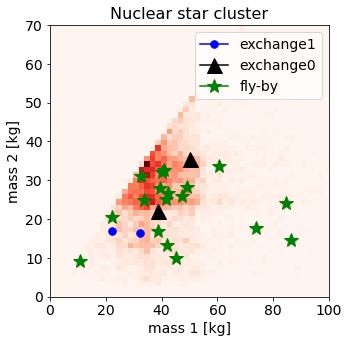

In [94]:
#TBS_1161 - ex1
m1161_1 = NSC_merge['m'][0]
m1161_2 = NSC_merge['m'][2]
#TBS_5480 - ex0
m5480_1 = NSC_merge['m'][5]
m5480_2 = NSC_merge['m'][4]
#TBS_3037 - fb
m3037_1 = NSC_merge['m'][6]
m3037_2 = NSC_merge['m'][7]
#TBS_5435 - fb
m5435_1 = NSC_merge['m'][9]
m5435_2 = NSC_merge['m'][10]
#TBS_2252 - fb
m2252_1 = NSC_merge['m'][12]
m2252_2 = NSC_merge['m'][13]
#TBS_7198 - ex0
m7198_1 = NSC_merge['m'][17]
m7198_2 = NSC_merge['m'][16]
#TBS_8764 - fb
m8764_1 = NSC_merge['m'][18]
m8764_2 = NSC_merge['m'][19]
#TBS_2623 - fb
m2623_1 = NSC_merge['m'][21]
m2623_2 = NSC_merge['m'][22]
#TBS_8692 - fb
m8692_1 = NSC_merge['m'][24]
m8692_2 = NSC_merge['m'][25]
#TBS_3077 - fb
m3077_1 = NSC_merge['m'][27]
m3077_2 = NSC_merge['m'][28]
#TBS_3212 - fb
m3212_1 = NSC_merge['m'][30]
m3212_2 = NSC_merge['m'][31]
#TBS_2048 - fb
m2048_1 = NSC_merge['m'][33]
m2048_2 = NSC_merge['m'][34]
#TBS_4297 - fb
m4297_1 = NSC_merge['m'][36]
m4297_2 = NSC_merge['m'][37]
#TBS_6820 - fb
m6820_1 = NSC_merge['m'][39]
m6820_2 = NSC_merge['m'][40]
#TBS_5727 - fb
m5727_1 = NSC_merge['m'][42]
m5727_2 = NSC_merge['m'][43]
#TBS_6389 - fb
m6389_1 = NSC_merge['m'][45]
m6389_2 = NSC_merge['m'][46]
#TBS_1449 - fb
m1449_1 = NSC_merge['m'][48]
m1449_2 = NSC_merge['m'][49]
#TBS_9427 - fb
m9427_1 = NSC_merge['m'][51]
m9427_2 = NSC_merge['m'][52]
#TBS_6064 - ex1
m6064_1 = NSC_merge['m'][54]
m6064_2 = NSC_merge['m'][56]
#TBS_9492 - fb
m9492_1 = NSC_merge['m'][57]
m9492_2 = NSC_merge['m'][58]
#TBS_1878 - fb
m1878_1 = NSC_merge['m'][60]
m1878_2 = NSC_merge['m'][61]
#TBS_3446 - fb
m3446_1 = NSC_merge['m'][63]
m3446_2 = NSC_merge['m'][64]

fig = plt.figure(figsize=(5,5))
plt.title('Nuclear star cluster', fontsize = 16)
plt.hist2d(m1n/2e30, m2n/2e30, bins=50, range=[[0,100],[0, 70]], cmap=plt.cm.Reds)
plt.plot(m1161_1/2e30, m1161_2/2e30, marker='.', markersize=15, label='exchange1', c='blue')
plt.plot(m5480_1/2e30, m5480_2/2e30, marker='^', markersize=15, label='exchange0', c='black')
plt.plot(m3037_1/2e30, m3037_2/2e30, marker='*', markersize=15, label='fly-by', c='green')
plt.plot(m5435_1/2e30, m5435_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2252_1/2e30, m2252_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m7198_1/2e30, m7198_2/2e30, marker='^', markersize=15, c='black') #label='ex0'
plt.plot(m8764_1/2e30, m8764_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2623_1/2e30, m2623_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m8692_1/2e30, m8692_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m3077_1/2e30, m3077_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m3212_1/2e30, m3212_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2048_1/2e30, m2048_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m4297_1/2e30, m4297_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m6820_1/2e30, m6820_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m5727_1/2e30, m5727_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m6389_1/2e30, m6389_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m1449_1/2e30, m1449_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m9427_1/2e30, m9427_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m6064_1/2e30, m6064_2/2e30, marker='.', markersize=15, c='blue') #label='ex1' 
plt.plot(m9492_1/2e30, m9492_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m1878_1/2e30, m1878_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m3446_1/2e30, m3446_2/2e30, marker='*', markersize=15, c='green') #label='fb'
plt.xlabel('mass 1 [kg]', fontsize = 14)
plt.ylabel('mass 2 [kg]', fontsize = 14)
plt.tick_params(axis = "x", labelsize = 14)
plt.tick_params(axis = "y", labelsize = 14)
plt.legend(loc='best', fontsize = 14)
plt.show()
#fig.savefig("mass_2d_nuclear.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)